In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

DATA_FILE = '../../data/crypto-markets.csv'

df = pd.read_csv(DATA_FILE)
df.head()
 

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.488567e+09,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.603769e+09,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.542813e+09,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.298955e+09,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.168517e+09,0.3881,33.32


In [17]:
# filter data with a slug named "bitcoin"

btc_data = df.loc[df['slug'] == 'bitcoin']

sorted_btc_data = btc_data.sort_values('date', ascending= False)

sorted_btc_data['T-1'] = sorted_btc_data['close'].shift(-1)
sorted_btc_data['T-2'] = sorted_btc_data['close'].shift(-2)
sorted_btc_data['T-3'] = sorted_btc_data['close'].shift(-3)
sorted_btc_data['T-4'] = sorted_btc_data['close'].shift(-4)
sorted_btc_data['T-5'] = sorted_btc_data['close'].shift(-5)

sorted_btc_data['close_price_change%'] =(((sorted_btc_data['close']/sorted_btc_data['T-1'])- 1) * 100).map("{:.2f}%".format)

sorted_btc_data['MA_5'] = sorted_btc_data['close'].rolling(window=3, min_periods=1).mean()
sorted_btc_data['MA_5_change%'] = (
    (sorted_btc_data['MA_5'] / sorted_btc_data['close'].shift(-1) - 1) * 100)

sorted_btc_data.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,...,close_ratio,spread,T-1,T-2,T-3,T-4,T-5,close_price_change%,MA_5,MA_5_change%
2041,bitcoin,BTC,Bitcoin,2018-11-29,1,4269.00,4413.02,4145.77,4278.85,6.503348e+09,...,0.4980,267.25,4257.42,3820.72,3779.13,4009.97,3880.76,0.50%,4278.850000,0.503356
2040,bitcoin,BTC,Bitcoin,2018-11-28,1,3822.47,4385.90,3822.47,4257.42,7.280280e+09,...,0.7720,563.43,3820.72,3779.13,4009.97,3880.76,4347.11,11.43%,4268.135000,11.710227
2039,bitcoin,BTC,Bitcoin,2018-11-27,1,3765.95,3862.96,3661.01,3820.72,5.998720e+09,...,0.7908,201.95,3779.13,4009.97,3880.76,4347.11,4365.94,1.10%,4118.996667,8.993252
2038,bitcoin,BTC,Bitcoin,2018-11-26,1,4015.07,4107.14,3643.92,3779.13,6.476900e+09,...,0.2919,463.22,4009.97,3880.76,4347.11,4365.94,4602.17,-5.76%,3952.423333,-1.435090
2037,bitcoin,BTC,Bitcoin,2018-11-25,1,3880.78,4120.87,3585.06,4009.97,6.825640e+09,...,0.7930,535.81,3880.76,4347.11,4365.94,4602.17,4451.87,3.33%,3869.940000,-0.278811


In [19]:
# Drop rows with NaN values that are created due to shifting
sorted_btc_data = sorted_btc_data.dropna()

# Define features (X) and target (y)
X = sorted_btc_data[['T-1', 'T-2', 'T-3', 'T-4', 'T-5', 'MA_5_change%']]
y = sorted_btc_data['close']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Best k: 3
Test RMSE: 317.43


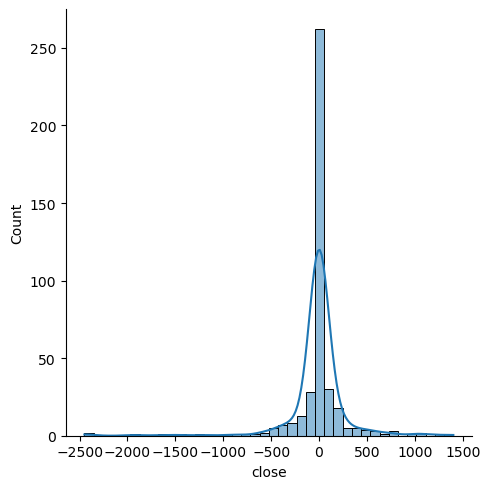

In [20]:
# Grid search with cross-validation on the training set
param_grid = {'n_neighbors': range(1, 21)}  # Test k from 1 to 20
knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
best_k = grid_search.best_params_['n_neighbors']
print(f"Best k: {best_k}")

# Train final KNN model with the best `k`
best_knn = grid_search.best_estimator_

# Evaluate on the test set
predicted = best_knn.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, predicted))
print(f"Test RMSE: {rmse:.2f}")


# Error distribution plot
error = y_test - predicted
sns.displot(error, kde=True, bins=40)

